<a href="https://colab.research.google.com/github/yeomko22/data_analytics_camp_2023_share/blob/main/week18_deeplearning_cv/ch18_3_cuda_acceleration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch18_3 CUDA 가속

이번 챕터에서는 GPU를 이용하여 빠르게 딥러닝 모델을 학습시킬 수 있는 방법에 대해서 배워보겠습니다.

## GPU 환경 설정

### colab GPU runtime

먼저 colab에서 GPU를 이용할 수 있도록 런타임 유형을 변경해줍니다.

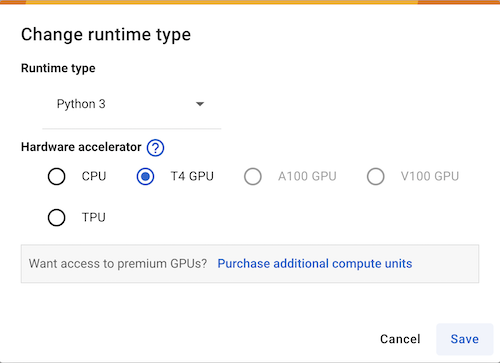

### CUDA 설치 확인

nvidia-smi 명령어를 이용해서 현재 환경에 CUDA가 잘 설치되어 있는지, GPU 하드웨어를 잘 인식하는지 확인해봅니다.

In [ ]:
!nvidia-smi

Mon Aug  7 13:50:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### torch cuda 사용 확인

그 다음 torch 라이브러리를 이용해서 CUDA를 사용할 수 있는지를 확인해봐야 합니다.

In [ ]:
import torch

torch.cuda.is_available()

True

CUDA 사용 가능 여부를 체크해서 모델 학습을 진행할 디바이스를 선택해줍니다.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

## GPU를 이용한 MNIST Classifier 학습

이제 GPU 가속을 이용해서 MNIST 이미지 분류 모델을 학습시켜 보겠습니다. 대부분의 코드는 이전 챕터에서 복사해옵니다.

### 데이터 셋 준비

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

batch_size = 32
train_dataset = MNIST(root="data", train=True, download=True, transform=ToTensor())
val_dataset = MNIST(root="data", train=False, download=True, transform=ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### 모델 작성

In [ ]:
import torch
from torch import nn


class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding="same")
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding="same")
        self.fc = nn.Linear(in_features=784, out_features=10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.softmax(self.fc(x))
        return x

모델 객체를 생성한 다음, to 함수를 호출하여 GPU로 보내줍니다.

In [ ]:
model = SimpleCNN().to(device)

nvidia-smi 명령어를 찍어보면 GPU 메모리에 모델이 로딩된 것을 확인할 수 있습니다.

In [ ]:
!nvidia-smi

Mon Aug  7 13:50:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |    601MiB / 15360MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 하이퍼 파라미터 셋팅

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

### 모델 학습

In [ ]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [ ]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        # 데이터를 GPU로 보내줌
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # 모델과 데이터가 같은 device에 있어야 연산이 가능
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        # 데이터를 GPU로 보내줌
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [ ]:
logs = train_validate_model(model)

100%|██████████| 313/313 [00:01<00:00, 177.14it/s]


epoch 1 train - loss: 1.5777 acc: 0.8925 val - loss: 1.5043 acc: 0.9596


100%|██████████| 313/313 [00:01<00:00, 192.13it/s]


epoch 2 train - loss: 1.4989 acc: 0.9648 val - loss: 1.4921 acc: 0.9704


100%|██████████| 313/313 [00:01<00:00, 187.68it/s]


epoch 3 train - loss: 1.4894 acc: 0.9734 val - loss: 1.4888 acc: 0.9733


100%|██████████| 313/313 [00:01<00:00, 211.32it/s]


epoch 4 train - loss: 1.4851 acc: 0.9771 val - loss: 1.4829 acc: 0.9794


100%|██████████| 313/313 [00:01<00:00, 238.06it/s]


epoch 5 train - loss: 1.4818 acc: 0.9801 val - loss: 1.4809 acc: 0.9814


100%|██████████| 313/313 [00:01<00:00, 242.63it/s]


epoch 6 train - loss: 1.4799 acc: 0.982 val - loss: 1.4806 acc: 0.9817


100%|██████████| 313/313 [00:01<00:00, 248.23it/s]


epoch 7 train - loss: 1.478 acc: 0.9837 val - loss: 1.4788 acc: 0.9828


100%|██████████| 313/313 [00:01<00:00, 247.24it/s]


epoch 8 train - loss: 1.4766 acc: 0.9851 val - loss: 1.4784 acc: 0.9834


100%|██████████| 313/313 [00:01<00:00, 252.59it/s]


epoch 9 train - loss: 1.4755 acc: 0.9862 val - loss: 1.4766 acc: 0.985


100%|██████████| 313/313 [00:01<00:00, 248.29it/s]

epoch 10 train - loss: 1.4747 acc: 0.987 val - loss: 1.4775 acc: 0.984


### 결과 시각화

In [ ]:
from matplotlib import pyplot as plt

def plot_loss_acc(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

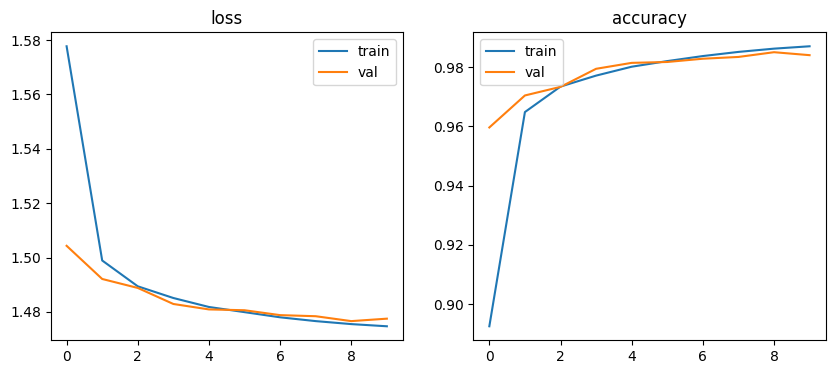

In [ ]:
plot_loss_acc(logs)

## 정리

이번 챕터에서는 CUDA를 이용해서 빠르게 이미지 분류 모델을 학습시킬 수 있는 방법에 대해서 알아보았습니다. torch를 이용하면 쉽게 CUDA를 사용할 수 있었습니다.